<a href="https://colab.research.google.com/github/dqj5182/Weight_Initialization_Method_using_Monte_Carlo_Simulation/blob/main/Default_Initialization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

In [3]:
data_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.RandomApply([transforms.RandomHorizontalFlip()]),
                                         transforms.RandomRotation(degrees=(-10, 10)),
                                         transforms.RandomAffine(degrees=0, translate=(.1, .1)),
                                         transforms.RandomApply([transforms.ColorJitter(brightness=(1, 1.2),
                                                                                        contrast=(1, 1.5),
                                                                                        saturation=(1, 1.5),
                                                                                        hue=(0, 0.5))]),
                                         transforms.RandomErasing(p=0.5, scale=(0.05, 0.05), ratio=(0.3, 3.3), value=0,
                                                                  inplace=False),
                                         transforms.Resize((75, 75)),
                                         transforms.Normalize((0.5,), (0.5,))])

batch_size = 100

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


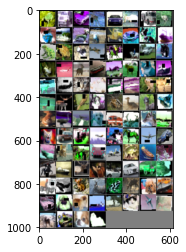

 frog truck   car  deer   car  deer truck  bird  ship  ship   dog  deer truck  frog   dog  ship  frog  frog   dog plane horse horse   car   cat  frog plane  deer  ship plane horse   cat  ship  deer plane   cat   cat plane  ship  frog horse  deer  deer  bird   dog  frog  bird  bird   dog   cat  bird plane   dog truck  deer  deer  ship   cat   car   car plane   dog horse plane   car  deer   cat  frog truck plane  frog  ship  bird horse  ship  deer   cat   car   car truck   cat truck plane   dog  deer  frog  deer   dog  ship   car   dog   dog  ship truck   cat plane  deer  deer  frog   dog   dog


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F


resnet50 = models.resnet50(pretrained=False)

n_inputs = resnet50.fc.in_features

last_layer = nn.Sequential(
                nn.Linear(n_inputs, len(classes)))

resnet50.fc = last_layer

if train_on_gpu:
    resnet50.cuda()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

# Exponential Decay to strengthen learning
decayRate = 0.999
my_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

In [7]:
def train_model(train_loader, optimizer, resnet50, criterion, my_lr_scheduler, n_epochs):
    # track training loss over time
    losses = []
    
    for epoch in range(1, n_epochs + 1):

        # keep track of training and validation loss
        train_loss = 0.0

        # model by default is set to train
        for batch_i, (data, target) in enumerate(train_loader):
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = resnet50(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()

            my_lr_scheduler.step()

            if batch_i % 100 == 99:  # print training loss every specified number of mini-batches
                print('Epoch %d, Batch %d loss: %.16f' %
                    (epoch, batch_i + 1, train_loss / 100))
                losses.append(train_loss / 100)
                train_loss = 0.0

    return resnet50, losses

In [8]:
n_epochs = 10

resnet50, train_losses = train_model(train_loader, optimizer, resnet50, criterion, my_lr_scheduler, n_epochs)

Epoch 1, Batch 100 loss: 2.2152708458900450
Epoch 1, Batch 200 loss: 1.8235893893241881
Epoch 1, Batch 300 loss: 1.6858886551856995
Epoch 1, Batch 400 loss: 1.5821185016632080
Epoch 1, Batch 500 loss: 1.5060761094093322
Epoch 2, Batch 100 loss: 1.4074768912792206
Epoch 2, Batch 200 loss: 1.3635329568386079
Epoch 2, Batch 300 loss: 1.3222825539112091
Epoch 2, Batch 400 loss: 1.2789640533924103
Epoch 2, Batch 500 loss: 1.2390128940343856
Epoch 3, Batch 100 loss: 1.1703820526599884
Epoch 3, Batch 200 loss: 1.1367419916391373
Epoch 3, Batch 300 loss: 1.0894987213611602
Epoch 3, Batch 400 loss: 1.0697573685646058
Epoch 3, Batch 500 loss: 1.0441046524047852
Epoch 4, Batch 100 loss: 0.9922881293296814
Epoch 4, Batch 200 loss: 0.9808182090520858
Epoch 4, Batch 300 loss: 0.9524764889478683
Epoch 4, Batch 400 loss: 0.9094631171226502
Epoch 4, Batch 500 loss: 0.9148067861795426
Epoch 5, Batch 100 loss: 0.8601242142915726
Epoch 5, Batch 200 loss: 0.8640690821409226
Epoch 5, Batch 300 loss: 0.84977

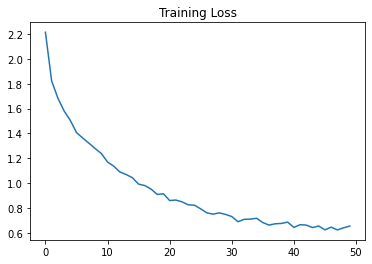

In [9]:
plt.plot(train_losses)
plt.title("Training Loss")
plt.show()

In [10]:
def test_model(classes, resnet50, test_loader, criterion):
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))

    resnet50.eval()  # eval mode

    labels = []
    predictions = []
    # iterate over test data
    for data, target in test_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = resnet50(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update  test loss
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(len(target.data)):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1
        
        # Will be used for calculating Recall, Precision, and F1-score
        labels.extend(target.data.view_as(pred).tolist())
        predictions.extend(pred.tolist())


    # calculate avg test loss
    test_loss = test_loss / len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    return test_loss, class_correct, class_total, labels, predictions

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [12]:
# The test_model function is from model_testing python file
test_loss, class_correct, class_total, labels, predictions = test_model(classes, resnet50, test_loader, criterion)

# Test accuracy for each hieroglyph
for i in range(len(classes)):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (classes[i], 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# Total Test accuracy
print("\nAccuracy: {:.3%}".format(accuracy_score(labels, predictions)))
print("\nPrecision: {:.3%}".format(precision_score(labels, predictions, average = 'weighted')))
print("\nRecall: {:.3%}".format(recall_score(labels, predictions, average = 'weighted')))
print("\nF1-score: {:.3%}".format(f1_score(labels, predictions, average = 'weighted')))

Test Loss: 0.701356

Test Accuracy of plane: 80% (804/1000)
Test Accuracy of   car: 88% (889/1000)
Test Accuracy of  bird: 63% (638/1000)
Test Accuracy of   cat: 56% (568/1000)
Test Accuracy of  deer: 70% (705/1000)
Test Accuracy of   dog: 65% (659/1000)
Test Accuracy of  frog: 82% (820/1000)
Test Accuracy of horse: 80% (801/1000)
Test Accuracy of  ship: 86% (866/1000)
Test Accuracy of truck: 85% (850/1000)

Accuracy: 76.000%

Precision: 75.845%

Recall: 76.000%

F1-score: 75.907%
